# Отбор признаков в задачах машинного обучения. Часть 1.  

Часто наборы данных, с которыми приходится работать, содержат большое количество признаков, число которых может достигать нескольких сотен и даже тысяч. При построении модели машинного обучения не всегда понятно, какие из признаков действительно для неё важны (т.е. имеют связь с целевой переменной), а какие являются избыточными (или шумовыми). Удаление избыточных признаков позволяет лучше понять данные, а также сократить время настройки модели, улучшить её точность и облегчить интерпретируемость. Иногда эта задача и вовсе может быть самой значимой, например, нахождение оптимального набора признаков может помочь расшифровать механизмы, лежащие в основе исследуемой проблемы. Это может быть полезным для разработки различных методик, например, банковского скоринга, поиска фрода или медицинских диагностических тестов. Методы отбора признаков обычно делят на 3 категории: фильтры (filter methods), встроенные методы (embedded methods) и обёртки (wrapper methods). Выбор подходящего метода не всегда очевиден и зависит от задачи и имеющихся данных. Цель настоящего цикла статей - провести краткий обзор некоторых популярных методов отбора признаков с обсуждением их достоинств, недостатков и особенностей реализации. Первая часть посвещена фильтрам и встроенным методам.  
   
## 1. Методы фильтрации

Методы фильтрации применяются до обучения модели и, как правило, имеют низкую стоимость вычислений. К ним можно отнести визуальный анализ (например, удаление признака, у которого только одно значение, или большинство значений пропущено), оценку признаков с помощью какого-нибудь статистического критерия (дисперсии, корреляции, $\chi^2$ и др.) и экспертную оценку (удаление признаков, которые не подходят по смыслу, или признаков с некорректными значениями). 

Простейшим способом оценки пригодности признаков является разведочный анализ данных (например, с библиотекой [pandas-profiling](https://newtechaudit.ru/uskoryaem-analiz-dannyh-c-pomoshhyu-pandas-profiling/)). Эту задачу можно автоматизировать с помощью библиотеки [feature-selector](https://github.com/WillKoehrsen/feature-selector), которая отбирает признаки по следующим параметрам:
- Количество пропущенных значений (удаляются признаки у которых процент пропущенных значений больше порогового).
- Коэффициент корреляции (удаляются признаки, у которых коэффициент корреляции больше порогового).
- Вариативность (удаляются признаки, состоящие из одного значения).
- Оценка важности признаков с помощью lightgbm (удаляются признаки, имеющие низкую важность в модели lightgbm. Следует применять только если lightgbm имеет хорошую точность.)

Туториал по этой библиотеке находится [здесь](https://github.com/WillKoehrsen/feature-selector/blob/master/).

Более сложные методы автоматического отбора признаков реализованы в sklearn. [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold) отбирает признаки, у которых дисперсия меньше заданного значения. [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) и [SelectPercentile](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile) оценивают взаимосвязь предикторов с целевой переменной используя статистические тесты, позволяя отобрать соответственно заданное количество и долю наилучших по заданному критерию признаков. В качестве статистических тестов используются F-тест, $\chi^2$ и взаимная информация.

### F-тест

F-тест оценивает степень линейной зависимости между предикторами и целевой переменной, поэтому он лучше всего подойдёт для линейных моделей. Реализован в sklearn как [f_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression) и [f_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) соответственно для регрессии и классификации.

### $\chi^2$

Этот тест используется в задах классификации и оценивает зависимость между признаками и классами целевой пременной. Описание метода приведено [здесь](https://habr.com/ru/post/264915/) и [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2) (для sklearn). Стоит отметить, что этот тип тестов требует неотрицательных и правильно отмасштабированных признаков.

### Взаимная информация

Взаимная информация показывает насколько чётко определена целевая переменная если известны значения предиктора (подробнее [здесь](https://habr.com/ru/post/264915/) и [здесь](http://www.machinelearning.ru/wiki/images/2/21/PZAD2017_09_featureselection.pdf)). Этот тип тестов считается самым удобным в использовании - он хорошо работает "из коробки" и позволяет находить нелинейные зависимости. Реализован в sklearn как [mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression) и [mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif) соответственно для регрессии и классификации.

## 2. Встроенные методы

Встроенные методы выполняют отбор признаков во время обучения модели, оптимизируя их набор для достижения лучшей точности. К этим методам можно отнести регуляризацию в линейных моделях (обычно L1) и расчёт важности признаков в алгоритмах с деревьями (который хорошо разобран [здесь](https://mlcourse.ai/articles/topic5-part3-feature-importance/#3.-Sklearn-Random-Forest-Feature-Importance)). Отметим, что для линейных моделей требуется масштабирование и нормализация данных.   


## Пример
Рассмотрим применение описанных выше методов в реальной [задаче](https://archive.ics.uci.edu/ml/datasets/Adult) – предсказать, зарабатывает ли человек больше $50 тыс. Загрузим библиотеки и данные, для удобства оставив только численные признаки:
- age – возраст
- fnlwgt (final weight) – примерная оценка количества людей, которое представляет каждая строка данных
- educational-num – длительность обучения
- capital-gain – прирост капитала
- capital-loss – потеря капитала
- hours-per-week – количество рабочих часов в неделю

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression

# зафиксируем значение генератора случайных чисел для воспроизводимости 
SEED = 1

# Функции, которые в дальнейшем понадобятся
def plot_features_scores(model, data, target, column_names, model_type):
    '''Функция для визуализации важности признаков'''
    
    model.fit(data, target)
    
    if model_type == 'rf':
        (pd.DataFrame(data={'score': model['rf'].feature_importances_}, 
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
    elif model_type == 'lr':
        (pd.DataFrame(data={'score': model['lr'].coef_[0]},
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
        
    else:
        raise KeyError('Unknown model_type')

def grid_search(model, gs_params):
    '''Функция для подбора гиперпараметров с помощью перекрёстной проверки'''
     
    gs = GridSearchCV(estimator=model, param_grid=gs_params, refit=True,
                      scoring='roc_auc', n_jobs=-1, cv=skf, verbose=0)
    gs.fit(X, y)
    scores = [gs.cv_results_[f'split{i}_test_score'][gs.best_index_] for i in range(5)]
    print('scores = {}, \nmean score = {:.5f} +/- {:.5f} \
           \nbest params = {}'.format(scores,
                                      gs.cv_results_['mean_test_score'][gs.best_index_],
                                      gs.cv_results_['std_test_score'][gs.best_index_],
                                      gs.best_params_))
    return gs
        
# загрузим данные        
df = pd.read_csv(r'..\adult.data.csv')

# датасет, с которым будем работать
# оставим только численые признаки
X = df.select_dtypes(exclude=['object']).copy()
# преобразуем целевую переменную
y = df['salary'].map({'<=50K':0, '>50K':1}).values

X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [2]:
X.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Посмотрим точность на кросс-валидации и важность признаков для случайного леса:

scores = [0.82427915 0.82290796 0.83106668 0.8192637  0.83155106] 
mean score = 0.82581 +/- 0.00478


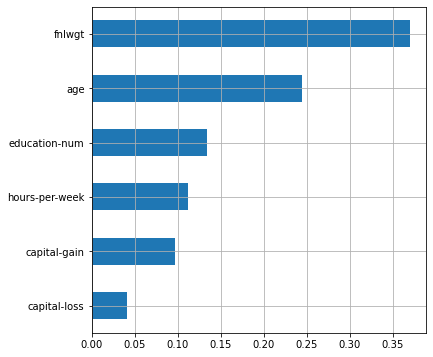

In [3]:
rf = Pipeline([('rf', RandomForestClassifier(n_jobs=-1, 
                                             class_weight='balanced', 
                                             random_state=SEED))])

# параметры кросс-валидации (стратифицированная 5-фолдовая с перемешиванием) 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

scores = cross_val_score(estimator=rf, X=X, y=y, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

# важность признаков
plot_features_scores(model=rf, data=X, target=y, column_names=X.columns, model_type='rf')

Самым важным признаком для случайного леса является fnlwgt. Это можно интерпретировать как то, что главным фактором того, что человек зарабатывает больше $50 тыс. является количество людей с такими же характеристиками. Такая интерпретация выглядит нелогичной, и происходит это потому, что модели с деревьями могут выдавать сильно смещённую оценку признаков (подробнее [здесь](https://explained.ai/rf-importance/)). Притом, чем хуже настроена модель, тем сильнее может быть смещение, поэтому доверять оценкам таких моделей надо с осторожностью. 

Повторим процедуру для линейной модели (с L1-регуляризацией). Для нормализации данных будем использовать метод [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer).

scores = [0.82034993 0.83000963 0.8348707  0.81787667 0.83548066] 
mean score = 0.82772 +/- 0.00732


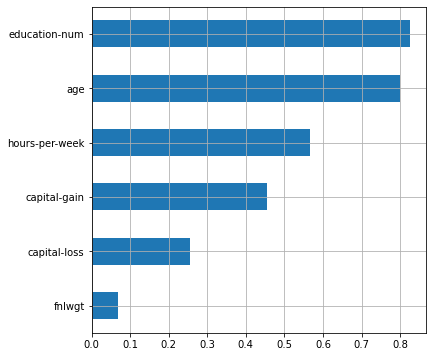

In [4]:
lr = Pipeline([('p_trans', PowerTransformer(method='yeo-johnson', standardize=True)),
               ('lr', LogisticRegression(solver='liblinear',
                                         penalty='l1',
                                         max_iter=200,
                                         class_weight='balanced',
                                         random_state=SEED)
               )])
scores = cross_val_score(estimator=lr, X=X, y=y, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

plot_features_scores(model=lr, data=X, target=y, column_names=X.columns, model_type='lr')

Создадим 12 шумовых признаков, элементами которых будут некоррелируемые случайные числа из выборок с нормальным, равномерным и Лапласовым распределениями. Параметры каждого распределения подбираются случайным образом независимо друг от друга.

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,norm_0,unif_0,lapl_0,norm_1,unif_1,lapl_1,norm_2,unif_2,lapl_2,norm_3,unif_3,lapl_3
0,39,77516,13,2174,0,40,0.246454,4.996750,2.311467,6.474587,6.431455,-0.932124,3.773136,3.382773,-1.324387,8.031167,2.142457,8.050902
1,50,83311,13,0,0,13,-4.656718,4.693542,2.095298,14.622329,2.795007,6.465348,-3.275117,3.787041,0.652694,7.537461,5.247103,9.014559
2,38,215646,9,0,0,40,12.788669,4.255611,22.278713,9.643720,3.533265,2.716441,4.725608,3.126107,23.410698,1.932907,4.933431,13.233319
3,53,234721,7,0,0,40,-15.713848,3.989797,5.971506,8.978198,7.772238,-5.402306,5.742672,3.084132,0.937932,9.435720,4.915537,-3.396526
4,28,338409,13,0,0,40,20.703306,3.159246,8.718559,8.217148,4.365603,14.403088,3.023828,6.934299,4.978327,7.355296,2.551361,10.479218


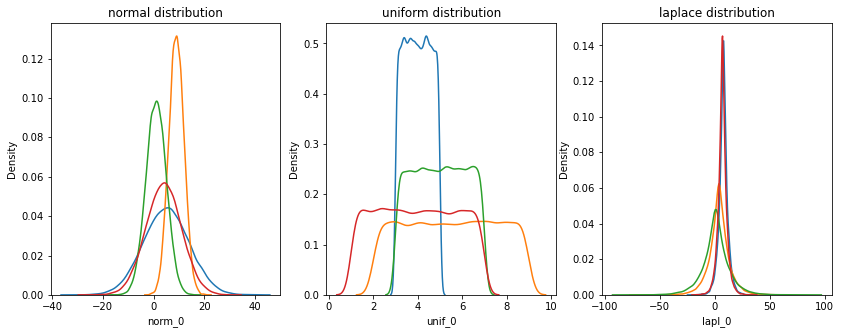

In [5]:
# утановим значение генератора случайных чисел для воспроизводимости
np.random.seed(SEED)

fix, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,5))
ax1.set_title("normal distribution")
ax2.set_title("uniform distribution")
ax3.set_title("laplace distribution")
for i in range(4):
    X.loc[:, f'norm_{i}'] = np.random.normal(loc=np.random.randint(low=0, high=10), 
                                             scale=np.random.randint(low=1, high=10), 
                                             size=(X.shape[0], 1))
    
    X.loc[:, f'unif_{i}'] = np.random.uniform(low=np.random.randint(low=1, high=4), 
                                              high=np.random.randint(low=5, high=10), 
                                              size=(X.shape[0], 1))
    X.loc[:, f'lapl_{i}'] = np.random.laplace(loc=np.random.randint(low=0, high=10), 
                                              scale=np.random.randint(low=1, high=10), 
                                              size=(X.shape[0], 1))
    # визуализирукем распределения признаков
    sns.kdeplot(X[f'norm_{i}'], ax=ax1)
    sns.kdeplot(X[f'unif_{i}'], ax=ax2)
    sns.kdeplot(X[f'lapl_{i}'], ax=ax3)

# итоговый датасет
X.head()

Проведём кросс-валидацию на зашумлённых данных и посмотрим важность признаков: 

scores = [0.8522425  0.85382173 0.86249657 0.84897581 0.85443027] 
mean score = 0.85439 +/- 0.00447


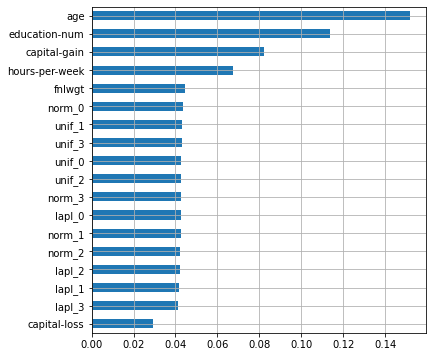

In [6]:
scores = cross_val_score(estimator=rf, X=X, y=y, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))
plot_features_scores(model=rf, data=X, target=y, column_names=X.columns, model_type='rf')

Несмотря на большое количество добавленных шумовых признаков, точность модели на кросс-валидации значительно возросла как на каждом фолде, так и в среднем! Кроме этого, все шумовые признаки имеют высокую важность, сравнимую с двумя оригинальными. Очевидно, что наша модель переобучена, однако в реальных задачах такие ситуации бывает очень сложно распознать, особенно когда при удалении некоторых признаков (про которые неизвестно – шумовые они, или нет) падает валидационная точность. Кроме того, часто бывает сложно подобрать пороговое значение важности признаков для исключения их из модели.

Посмотрим результаты для регрессии.

scores = [0.81993058 0.83005516 0.83446553 0.81763029 0.83543145] 
mean score = 0.82750 +/- 0.00738


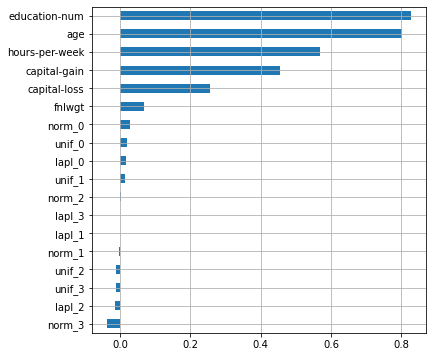

In [7]:
scores = cross_val_score(estimator=lr, X=X, y=y, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

plot_features_scores(model=lr, data=X, target=y, column_names=X.columns, model_type='lr')

После добавления шумовых признаков модель не преобучилась, к тому же эти признки имеют значительно меньшие коэффициенты, чем оригинальные. Отметим, что распределение коэффициентов в линейных моделях часто зависит от способа нормализации или масштабирования признаков.


Проведём отбор признаков статистическими методами, для чего будем использовать обобщённый вариант `SelectKBest` и `SelectPercentile`, который называется [GenericUnivariateSelect](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html#sklearn.feature_selection.GenericUnivariateSelect). Он принимает на вход 3 параметра – функцию оценки, режим отбора и его характеристики. В качестве функции оценки будем использовать взаимную информацию. 

In [8]:
selector = GenericUnivariateSelect(score_func=mutual_info_classif, 
                                   mode='k_best', 
                                   param=6)
# применим к нашему датасету
selector.fit(X, y)
# метод transform вернёт массив с отобраными признаками
# выведем результаты оценки каждого признака 
pd.DataFrame(data={'score':selector.scores_,
                   'support':selector.get_support()}, 
             index=X.columns).sort_values(by='score',ascending=False)

,score,support
capital-gain,0.080221,True
age,0.065703,True
education-num,0.064743,True
hours-per-week,0.043655,True
capital-loss,0.033617,True
fnlwgt,0.033390,True
norm_3,0.003217,False
unif_3,0.002696,False
norm_0,0.002506,False
norm_2,0.002052,False


Сгенерированные нами признаки имеют низкое значение оценочной функции (`scores_`), поэтому в дальнейшем селектор не будет их использовать (`get_support()=False`). 

В реальной задаче (когда количество шумовых признаков неизвестно) параметры `GenericUnivariateSelect` можно находить на кросс-валидации вместе с другими гиперпараметрами модели. Посмотрим, как изменится точность классификаторов после подбора их гиперпараметров, а также количества признаков селектора:

In [9]:
# добавим селектор в пайплайн к случайному лесу
selector = ('selector', GenericUnivariateSelect(score_func=mutual_info_classif, 
                                                mode='k_best'))
rf.steps.insert(0, selector)

    
# grid search
rf_params = {'selector__param': np.arange(4,10),
             'rf__max_depth': np.arange(2, 16, 2),
             'rf__max_features': np.arange(0.3, 0.9, 0.2)}
print('grid search results for rf')
rf_grid = grid_search(model=rf, gs_params=rf_params)

grid search results for rf
scores = [0.8632776968200635, 0.8683443340928604, 0.8710308000627435, 0.8615748939138762, 0.8693334091828478], 
mean score = 0.86671 +/- 0.00364            
best params = {'rf__max_depth': 12, 'rf__max_features': 0.3, 'selector__param': 5}


Для случайного леса средняя точность на кросс-валидации значительно выросла, а лучший результат получился всего для 5 признаков:

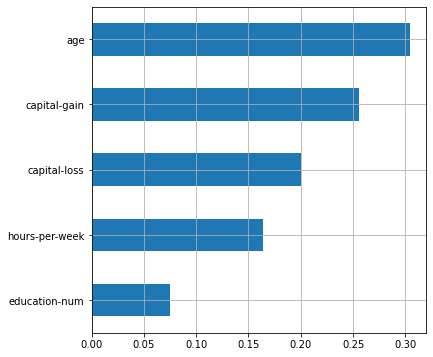

In [10]:
# выведем признаки, отобранные селектором
selected_features = [X.columns[i] for i, support
                     in enumerate(rf_grid.best_estimator_['selector'].get_support()) if support]

plot_features_scores(model=rf_grid.best_estimator_, 
                     data=X, target=y, column_names=selected_features, model_type='rf')

Этот результат был получен после удаления шумовых признаков и признака fnlwgt, который при первоначальной оценке был самым значимым для модели. Однако из всех оригинальных признаков он имел наименьшее значение оценочной функции в `GenericUnivariateSelect`. Результаты оценки важности признаков после их отбора и настройки модели имеют более логичную интерпретацию – на заработок человека влияют именно характеристики человека, а не параметры самой выборки. Таким образом, статистический отбор признаков бывает полезен для увеличения точности некоторых типов моделей и получения менее смещённой оценки при интерпретации их результатов.


Посмотрим, как изменятся коэффиценты у признаков после подбора коэффициента регуляризации у логистической регрессии.

grid search results for lr
scores = [0.820445329307105, 0.829874053687009, 0.8346493482101578, 0.8177211039148669, 0.8354590546776963], 
mean score = 0.82763 +/- 0.00729            
best params = {'lr__C': 0.01}


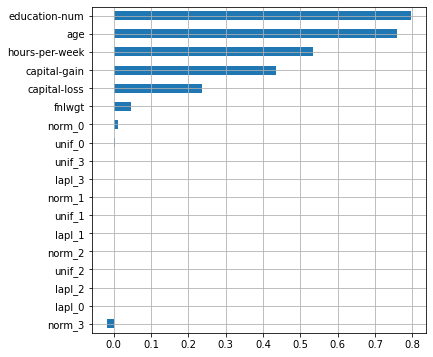

In [11]:
lr_params = {'lr__C': np.logspace(-3, 1.5, 10)}
             
print('grid search results for lr')
lr_grid = grid_search(model=lr, gs_params=lr_params)

plot_features_scores(model=lr_grid.best_estimator_, 
                     data=X, target=y, column_names=X.columns, model_type='lr')

Средняя точность на кросс-валидации почти не изменилась, но скорректировались коэффициенты у шумовых признаков. Отметим, что сильная регуляризация (L1) может занулить излишнее количество признаков.

Отобранные линейной моделью признаки можно подать на вход другой модели. Для этого воспользуемся методом [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel), дадим ему на вход нашу настроенную линейную модель и обозначим граничное значение для отбора коэффициентов.

In [12]:
lr_selector = SelectFromModel(estimator=lr_grid.best_estimator_['lr'], prefit=True, threshold=0.1)

# посмотрим выбранные признаки признаки
pd.DataFrame(data={'score':lr_selector.estimator.coef_[0],
                   'support':lr_selector.get_support()}, 
             index=X.columns).sort_values(by='score',ascending=False)

,score,support
education-num,0.796547,True
age,0.759419,True
hours-per-week,0.534709,True
capital-gain,0.435187,True
capital-loss,0.237207,True
fnlwgt,0.046698,False
norm_0,0.010349,False
unif_0,0.002101,False
norm_2,0.000000,False
unif_3,0.000000,False


## Заключение.

В статье были рассмотрено использование фильтров и встроенных методов в задаче отбора признаков. К достоинствам фильтров можно отнести низкую стоимость вычислений (линейно зависит от количества признаков) и интерпретируемость. К недостаткам – то, что они рассматривают каждый признак изолировано, поэтому не могут выявить более сложные зависимости в данных, например, зависимость от нескольких предикторов. Эти методы хорошо подойдут, если в данных большое количество признаков, но малое количество объектов (что встречается, например, в медицинских, или биологических исследованиях).

Встроенные методы, в отличие от фильтров, требуют больших вычислительных ресурсов, а так же более точной настройки и подготовки данных. Однако, эти методы могут выявить уже более сложные зависимости. Для менее смещённой интерпретации коэффициентов признаков необходимо настроить регуляризацию модели. Важно помнить, что распределение коэфициентов у линейных моделей зависит от способа предобработки данных.  

Описанные в статье методы отбора признаков можно комбинировать, либо сравнивать и подбирать их гиперпараметры используя средства sklearn или [специальных библиотек](https://github.com/stmyst/ML-notebooks/blob/master/hyperopt.ipynb).